In [1]:
from read_data import read_enhanced_microscore_dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from plots import first_plot, second_plot, third_plot, forth_plot, plot_performance, fith_plot
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer

In [2]:
df = read_enhanced_microscore_dataset()

In [3]:
df_base = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    'Caracteristicas'
]]

In [4]:
df_microscore = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    "RentaBrutaHogar",
    "RentaBrutaPersona",
    "poblacion_2023",
    "%_servicios",
    "densidad_inm_m2",
    "%_agricultura",
    "%_industria",
    "%_construccion",
    'Caracteristicas',
    'University_Distance',
    'School_Distance', 'Kindergarten_Distance', 'City Center_Distance',
       'Supermarket_Distance', 'Bakery_Distance', 'Hospital_Distance',
       'Pharmacy_Distance', 'Restaurant_Distance', 'Café_Distance',
       'Park_Distance', 'Gym_Distance', 'Movie Theater_Distance',
       'Theater_Distance', 'Shopping Mall_Distance', 'Bus Stop_Distance',
       'Metro Station_Distance', 'Score'
]]

In [5]:
def prepare_data(df):
    categorical_cols = ['Caracteristicas']
    df = pd.get_dummies(df, columns=categorical_cols)
    df = df.fillna(-1)
    return df

In [6]:
df_base =prepare_data(df_base)
df_microscore =prepare_data(df_microscore)

In [7]:
def grid_search(df):
    X = df.drop(columns=['Precio'])
    y = df['Precio']
    
    # Split dataset 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
    
    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Parametros gridsearch
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0] 
    }
    
    lasso = Lasso(random_state=56)
    
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=lasso,
        param_grid=param_grid,
        scoring=scorer,
        cv=5,  
        n_jobs=-1,  
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_alpha = grid_search.best_params_['alpha']
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Best Alpha: {best_alpha}")
    print(f"Mean Absolute Error on Test Set: {mae}")


In [8]:
grid_search(df_base)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Alpha: 10.0
Mean Absolute Error on Test Set: 108546.29721134841


In [10]:
grid_search(df_microscore)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Alpha: 10.0
Mean Absolute Error on Test Set: 91157.6101358151

Lasso Coefficients:
                         Feature   Coefficient
1                          Aseos  93517.812286
5                         Metros  87063.245523
9              RentaBrutaPersona  62074.061302
7                       Longitud  43493.862856
12               densidad_inm_m2  35322.439747
3                        Piscina  29343.909760
11                   %_servicios  27517.727679
29              Theater_Distance  11636.867756
8                RentaBrutaHogar  10086.029650
4                         Garaje   8460.190896
17               School_Distance   7492.532652
2                        Terraza   6995.944123
16           University_Distance   6396.545911
10                poblacion_2023   6040.242273
15                %_construccion   5930.978851
13                 %_agricultura   5788.805568
14                   %_industria   5007.474274
30    

C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+13, tolerance: 5.337e+11
  model = cd_fast.enet_coordinate_descent(


In [11]:
def lasso_kfold(df, alpha):
    X = df.drop(columns=["Precio"])  
    y = df["Precio"]  
    
    # KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=56)
    
    mae_list = []
    rmse_list = []
    mape_list = []
    
    # 5-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Escalado
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamiento Lasso Regression model
        lasso_model = Lasso(alpha=alpha, random_state=56)
        lasso_model.fit(X_train_scaled, y_train)
        
        # Prediccion
        y_pred = lasso_model.predict(X_test_scaled)
        
        # Metricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
        
        print(f"Fold MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average RMSE: {np.mean(rmse_list):.2f}")
    print(f"Average MAPE: {np.mean(mape_list):.2%}")
    
    # Entrenamiento con todo el dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso_model = Lasso(alpha=alpha, random_state=42)
    lasso_model.fit(X_scaled, y)
    
    # Coeficientes segun su importancia
    lasso_coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lasso_model.coef_
    }).sort_values(by='Coefficient', ascending=False)
    
    print("\nFeature Coefficients:")
    print(lasso_coefficients)

    return y_test, y_pred


In [12]:
y_test_base, y_pred_base = lasso_kfold(df_base, 10)

Fold MAE: 108546.30, RMSE: 204368.37, MAPE: 58.95%
Fold MAE: 109937.80, RMSE: 210859.57, MAPE: 58.42%
Fold MAE: 110671.89, RMSE: 230804.19, MAPE: 57.15%
Fold MAE: 107447.80, RMSE: 197024.80, MAPE: 58.13%
Fold MAE: 109868.09, RMSE: 205424.23, MAPE: 58.47%

--- Cross-Validation Metrics ---
Average MAE: 109294.38
Average RMSE: 209696.23
Average MAPE: 58.22%

Feature Coefficients:
                         Feature    Coefficient
1                          Aseos  115851.048974
7                       Longitud   85018.305575
5                         Metros   83331.389188
3                        Piscina   26146.843709
8      Caracteristicas_Apartment   25233.625626
4                         Garaje    8680.945008
0                   Habitaciones    3060.104825
2                        Terraza    2506.810950
10         Caracteristicas_House      -0.000000
9   Caracteristicas_CountryHouse   -1370.650590
6                        Latitud  -27128.091359


In [13]:
y_test_micro, y_pred_micro = lasso_kfold(df_microscore, 10)

C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.326e+12, tolerance: 4.445e+11
  model = cd_fast.enet_coordinate_descent(


Fold MAE: 93292.23, RMSE: 181999.76, MAPE: 53.57%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.144e+12, tolerance: 4.425e+11
  model = cd_fast.enet_coordinate_descent(


Fold MAE: 94800.06, RMSE: 188517.17, MAPE: 54.18%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e+12, tolerance: 4.204e+11
  model = cd_fast.enet_coordinate_descent(


Fold MAE: 94189.97, RMSE: 209810.30, MAPE: 51.52%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e+12, tolerance: 4.504e+11
  model = cd_fast.enet_coordinate_descent(


Fold MAE: 91224.83, RMSE: 173288.68, MAPE: 52.04%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e+12, tolerance: 4.460e+11
  model = cd_fast.enet_coordinate_descent(


Fold MAE: 94188.83, RMSE: 183315.68, MAPE: 53.69%

--- Cross-Validation Metrics ---
Average MAE: 93539.18
Average RMSE: 187386.32
Average MAPE: 53.00%

Feature Coefficients:
                         Feature   Coefficient
1                          Aseos  97185.893498
5                         Metros  83801.208276
9              RentaBrutaPersona  57546.763653
7                       Longitud  42302.630213
12               densidad_inm_m2  34908.158640
11                   %_servicios  32906.345651
3                        Piscina  30379.211667
8                RentaBrutaHogar  13434.872070
29              Theater_Distance  12393.392387
4                         Garaje   9001.204056
14                   %_industria   8969.781924
17               School_Distance   8045.209771
16           University_Distance   7974.285434
15                %_construccion   7324.495942
2                        Terraza   7055.896962
13                 %_agricultura   6283.594756
30        Shopping Mall_Dis

C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.715e+12, tolerance: 5.510e+11
  model = cd_fast.enet_coordinate_descent(


C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_blue = df_plot_base.groupby("log_bin")["%error"].mean().reset_index()
C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_red = df_plot__micro.groupby("log_bin")["%error"].mean().reset_index()


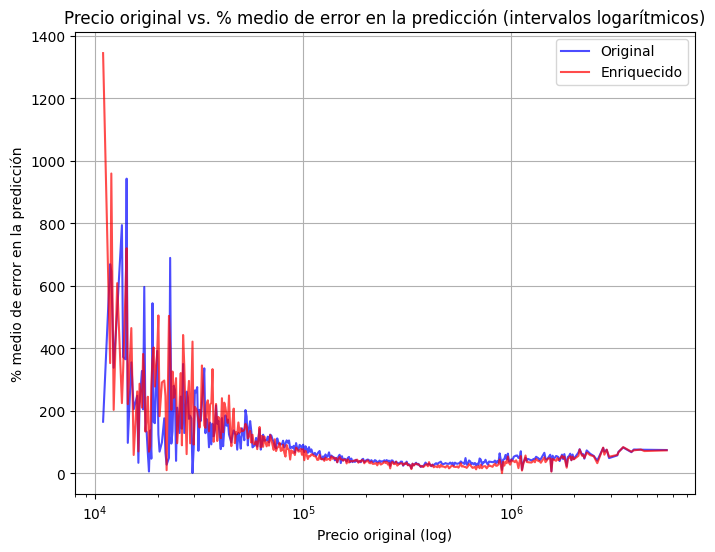

In [14]:
fith_plot(y_test_base, y_pred_base, y_test_micro, y_pred_micro)